In [1]:
from coffea import hist
import math

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
import random
from itertools import chain

plt.style.use(hep.style.CMS)

import awkward as ak

from matplotlib import colors
POPTS={'norm':colors.LogNorm()}

In [2]:
from data import getData, repackage
ldmx_dict = getData(chunks=True, fnames="/Users/chloeg/Desktop/Work/Fermilab2021/HistData/kaon_pn_4GeV_Jul21_ntuple/*.root")




In [3]:
def extend_array(arr, new_attr, new_attr_name):
    members={n:arr[n] for n in arr.fields}
    members[new_attr_name] = new_attr
    return ak.zip(members)

def add_angle(arr,br=['px','py','pz','e'],name="theta"):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    arr = extend_array(arr, part.theta, name)
    return arr

def get_vector(arr):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    return part

def flat(x,axis=None): # for now must cast while waiting for coffea to catch up
    try:
        return ak.to_numpy(ak.flatten(x,axis=axis)) 
    except:
        return x

In [4]:
def pz_smear(pz):
    pz_array = []
    for part in pz:
        for element in part:
            if element <= 50:
                pz_perc = random.gauss(1,0.0404);
            elif element <= 100: 
                pz_perc = random.gauss(1,0.0410);
            elif element <= 250: 
                pz_perc = random.gauss(1,0.0415);
            elif element <= 500: 
                pz_perc = random.gauss(1,0.0420);
            elif element <= 1000: 
                pz_perc = random.gauss(1,0.0435);
            elif element <= 2000:  
                pz_perc = random.gauss(1,0.0477);
            elif element <= 3000:  
                pz_perc = random.gauss(1,0.0523);
            elif element <= 4000:  
                pz_perc = random.gauss(1,0.0573);            
            else:    
                pz_perc = random.gauss(1,0.06);
            pz_array=np.append(pz_array, [pz_perc])
    return (pz_array)

def px_smear(p):
    px_array = []
    for part in p:
        for element in part:
            if element <= 100:
                px_uncer = random.gauss(0,3.00);
            elif element <= 400: 
                px_uncer = random.gauss(0,3.20);
            elif element <= 500: 
                px_uncer = random.gauss(0,3.20);
            elif element <= 1000: 
                px_uncer = random.gauss(0,3.40);
            elif element <= 1300: 
                px_uncer = random.gauss(0,3.50);
            elif element <= 2000:  
                px_uncer = random.gauss(0,3.85);           
            else:    
                px_uncer = random.gauss(0,3.85);
            px_array=np.append(px_array, [px_uncer])
    return (px_array)


def py_smear(p):
    py_array = []
    for part in p:
        for element in part:
            if element <= 100:
                py_uncer = random.gauss(0,3.75);
            elif element <= 350: 
                py_uncer = random.gauss(0,3.80);
            elif element <= 500: 
                py_uncer = random.gauss(0,4.20);
            elif element <= 1000: 
                py_uncer = random.gauss(0,4.80);
            elif element <= 1200: 
                py_uncer = random.gauss(0,4.98);
            elif element <= 2000:  
                py_uncer = random.gauss(0,3.85);           
            else:    
                py_uncer = random.gauss(0,5.50);
            py_array=np.append(py_array, [py_uncer])
    return (py_array)


In [5]:
hists = {}

hists["px"] = hist.Hist("Sim Particles",  
                                hist.Bin("e", r"px [MeV]", 100, 0, 150),
                            )
hists["px_smeared"] = hist.Hist("Sim Particles",     
                                hist.Bin("e", r"px [MeV]", 100, 0, 150),
                            )
hists["py"] = hist.Hist("Sim Particles",     
                                hist.Bin("e", r"py [MeV]", 100, 0, 150),
                            )
hists["py_smeared"] = hist.Hist("Sim Particles",     
                                hist.Bin("e", r"py [MeV]", 100, 0, 150),
                            )
hists["pz"] = hist.Hist("Sim Particles",     
                                hist.Bin("e", r"pz [MeV]", 100, 0, 150),
                            )
hists["pz_smeared"] = hist.Hist("Sim Particles",     
                                hist.Bin("e", r"pz [MeV]", 100, 0, 150),
                            )

In [6]:
def ProcessChunk(chunk, hists):
    ldmx_events = repackage(chunk)
    
    sim_particle = ldmx_events['Sim_PNParticle']
    sim_particle_n = ldmx_events['n']['Sim_PNParticle']
    sim_particle_dau1 = ldmx_events['Sim_PNParticle_dau1']
    sim_particle_dau2 = ldmx_events['Sim_PNParticle_dau2']

    
    hists["px"].fill(e = flat(sim_particle_dau1.px))
    hists["py"].fill(e = flat(sim_particle_dau1.py))
    hists["pz"].fill(e = flat(sim_particle_dau1.pz))
    print(flat(sim_particle_dau1.pz))
    print((flat(sim_particle_dau1.pz)).shape)
    
    particlevector = get_vector(sim_particle_dau1)
 
    n_px = px_smear(particlevector.p)+flat(particlevector.px)
    n_py = py_smear(particlevector.p)+flat(particlevector.py)
    n_pz = pz_smear(particlevector.pz)*flat(particlevector.pz)

    hists["px_smeared"].fill(e = n_px) 
    hists["py_smeared"].fill(e = n_py)
    hists["pz_smeared"].fill(e = n_pz)
    print(n_pz)
    print((n_pz).shape)

In [7]:
nchunk = 0
percent = 0
for chunk in ldmx_dict:
    nchunk += 1
    print('process', nchunk) 
    ProcessChunk(chunk, hists)
    print()


process 1
[-158.20706   124.78472    38.372456 ...  -24.51265  -185.59349
   63.206047]
(5107,)
[-167.30610165  127.86743397   39.34549095 ...  -25.06488113 -193.06518824
   60.77466397]
(5107,)

process 2
[105.39552    69.280426   -1.4848034 ... 205.93765    -3.437174
 -48.179596 ]
(5073,)
[102.48497448  70.91152935  -1.43254602 ... 197.11334654  -3.61425829
 -45.35432541]
(5073,)

process 3
[ 50.802635   28.42976     5.7156653 ... -36.216816   -8.200393
 -33.639683 ]
(5098,)
[ 47.59727211  27.64524333   5.81472822 ... -35.67337851  -8.24141177
 -33.84126665]
(5098,)

process 4
[ 1.1066040e-02 -2.9205453e+02  5.1543549e+02 ...  2.0805019e+01
  4.8707161e+01  2.6700617e+01]
(4826,)
[ 1.09347526e-02 -2.99135944e+02  5.09397186e+02 ...  1.99813334e+01
  4.69271979e+01  2.61099484e+01]
(4826,)

process 5
[-9.2996567e+01  6.4340085e-01  7.3179150e+02 ...  3.8086902e+02
 -5.5912910e+01 -3.4107418e+01]
(5120,)
[-9.24527364e+01  6.53156696e-01  7.51283293e+02 ...  3.81100278e+02
 -5.43561365e

[-228.31298954  504.910352    139.03025984 ...    0.93348113 -301.34212554
    5.37210414]
(5483,)

process 42
[ 3.4309080e-01  8.2168114e+01  8.8432986e-01 ...  1.0735392e+03
  3.1017636e+02 -7.4134727e+00]
(5152,)
[ 3.36459340e-01  8.06382075e+01  8.75444895e-01 ...  1.20308542e+03
  3.21501467e+02 -7.24454833e+00]
(5152,)

process 43
[207.40302  -14.218525 265.50357  ... 634.648    -12.428922  15.123761]
(4964,)
[196.69163195 -14.01039189 261.57120588 ... 633.39561013 -11.8355609
  14.41004084]
(4964,)

process 44
[ 5.8281090e+01  1.2813126e-01  6.5272900e+02 ... -1.3478381e+02
  3.0227301e-03  4.2011816e+02]
(4956,)
[ 6.06288929e+01  1.35745979e-01  6.28054006e+02 ... -1.31165411e+02
  2.86423972e-03  4.41253376e+02]
(4956,)

process 45
[-31.747753    88.334175    75.34835    ...   0.49041235   6.881357
  57.78407   ]
(5105,)
[-31.05723848  89.19324899  73.7213001  ...   0.45384718   6.90813395
  55.61329641]
(5105,)

process 46
[ 96.564835  248.79182     5.0380125 ... 280.2226    

[ 16.44427936  -2.07586782  87.03448372 ... -22.56052177 801.49703228
 187.88589843]
(5117,)

process 82
[-6.09559864e-02  3.56354553e+02  1.02594709e-02  1.00300765e+00
  6.34189262e+01  9.84502025e-03  1.08030981e+03  9.75018787e+00
  1.08921528e+00  3.36444043e-02  8.98785828e+02 -3.69723778e+01
 -8.39624405e+01  9.03309692e+02 -4.87960625e+01  2.67867780e+00
 -2.58147065e-02  4.52276535e+01  1.33957657e+02  1.95739403e+01
 -6.27001495e+01  5.54733887e+01  1.24688053e+01 -1.99502218e+00
 -2.70154524e+00  2.08629990e+02  2.81535980e+02  4.00642426e+02
  2.74983185e+02  2.10203760e+03 -1.99638519e+01  1.94689102e+02
 -2.54247360e+02 -2.09781945e-01 -1.28455896e+01 -6.47862854e+01
  2.60588470e+02 -2.27626181e+00  8.09439003e-01  6.20690155e+00
  2.45193214e+01  7.63391284e-03 -2.55487709e+01  7.80125061e+02
  2.94894775e+02  1.27396362e+03 -1.69155006e+01  4.22921419e+00
  1.48266525e+02  2.41426987e+02  1.92725811e+01  8.88318598e-01
  3.99266928e-03  6.45759338e+02 -3.00014534e+01 -

process 83
[ 18.278011 149.51564  -68.43745  ... 100.158264 613.1797   402.10126 ]
(4928,)
[ 18.13522095 142.11118976 -69.31730936 ...  94.5821871  606.2703041
 398.63478487]
(4928,)

process 84
[697.8033   135.64983  -17.532421 ... 120.97844   24.187674  16.560234]
(5037,)
[729.94239309 137.89817723 -17.7236616  ... 119.31987528  22.94131142
  17.28360299]
(5037,)

process 85
[403.06253  469.31775  111.98362  ...  25.881262 -97.643425  -4.851859]
(5319,)
[ 398.7059274   461.30156701  112.59601216 ...   26.1638411  -104.98134998
   -4.58580932]
(5319,)

process 86
[ 1.0603429e+02  4.4743600e+02  7.6238831e+02 ...  5.6137031e-01
  8.2842462e+02 -1.2219334e+00]
(4967,)
[ 1.02692213e+02  4.68553825e+02  7.48589457e+02 ...  5.31578421e-01
  8.06106579e+02 -1.22992364e+00]
(4967,)

process 87
[-5.5876644e+01 -1.2789037e+01  4.0313244e+01 ...  2.1348836e-01
  3.5077216e+02  4.5920631e-01]
(5250,)
[-5.75467451e+01 -1.40628789e+01  4.11371063e+01 ...  2.08004931e-01
  3.58873022e+02  4.5646118

[-1.76443549e+02 -6.36903373e-01  1.42098033e+03 ...  2.64524300e+02
  9.55926044e+00  1.17955599e+01]
(5058,)

process 124
[1.8204711e-02 1.3847674e+01 5.7527197e+02 ... 6.9679024e+01 5.4849786e-01
 7.9014239e+00]
(5086,)
[1.80912521e-02 1.45209405e+01 5.69268639e+02 ... 6.48997373e+01
 5.52700133e-01 8.15566273e+00]
(5086,)

process 125
[-32.49279   500.57672   -29.718636  ...  13.676345   21.22661
  -4.6038613]
(4977,)
[-34.02775405 515.4621717  -29.26634576 ...  14.12402821  20.64564491
  -4.76002708]
(4977,)

process 126
[169.91853    14.271287  626.0214    ... 248.62355     1.7434036
  16.189655 ]
(5477,)
[161.68955643  13.67612686 642.0738686  ... 258.96895904   1.73673561
  15.81316263]
(5477,)

process 127
[334.72742  -39.06039   60.166523 ...  20.272116 -23.700426 -23.11026 ]
(5358,)
[326.8056658  -39.00997608  59.0722225  ...  21.46482528 -24.77781151
 -24.03262819]
(5358,)

process 128
[ 2.5870551e+02 -2.0092872e-01  3.2387213e+02 ...  1.0792414e+00
  1.5008181e+01 -1.63189

[-6.88585076e+00  6.08303303e+02  4.26971933e+01  2.16707930e+01
 -5.02859817e+01  5.59591413e+02  6.28916722e-01 -9.65262307e+00
 -4.01271634e+01 -6.55043814e+01  4.99993342e+01  2.77784177e+02
 -9.83250159e+01  4.24496265e-01  2.25336319e+01  3.08467519e+01
  8.99834682e+01  1.34152338e+02  3.20956179e+01  2.82178682e+01
 -1.29799325e+00 -4.38223275e+00  1.71595332e+02  2.20716553e+00
  2.05275489e+02  4.25090349e+02 -1.44683340e+01 -7.91299085e-03
  1.15757038e-02 -5.66857613e-01 -1.34643873e+01  4.06858214e+00
  1.42016989e+01  8.95086083e+01  2.21826145e-03  8.75915819e-01
 -9.66557822e+00  1.67334444e+01 -1.75775744e+01 -2.11770560e-02
  2.71352684e-01 -7.69298370e+01  7.01850250e-01 -1.13791619e+01
 -1.16051461e+02  2.55191769e+02 -1.06209901e+01  1.76949036e+01
  2.41679062e+02  4.74237578e-01 -2.63113888e+01 -6.45559924e+01
 -3.83596831e+01 -7.08911335e+01  7.92011165e+01 -2.26741052e+01
  3.46397625e+02  1.34946522e+01  6.43728992e+01  3.85062578e-01
  3.34489737e+02  2.74248

[ 4.6804028e+02  1.1525712e+03  1.1632176e+01 ...  5.6384212e+01
  4.7692676e+02 -7.8557938e-01]
(4924,)
[ 4.81029762e+02  1.18517642e+03  1.21081376e+01 ...  6.00862019e+01
  4.94240290e+02 -7.77436016e-01]
(4924,)

process 159
[ 1.9489159e+01  4.7464344e+01  1.8692310e-01 ...  2.9385660e+02
 -2.8970113e-01  1.6547926e+01]
(5212,)
[ 1.86196656e+01  4.51710097e+01  1.91868714e-01 ...  2.85866861e+02
 -3.01123480e-01  1.65786879e+01]
(5212,)

process 160
[ -1.9957602 342.29953   604.2247    ... 285.08182    10.024093
  20.905655 ]
(5466,)
[ -2.04613467 352.99726428 603.18852156 ... 277.67198678  10.25809553
  20.26215395]
(5466,)

process 161
[-51.817253   14.672367   -7.7822127 ...  43.2461     21.489023
  20.26334  ]
(5236,)
[-52.27626301  14.30102159  -7.95423109 ...  41.73251276  22.38760017
  20.08109124]
(5236,)

process 162
[-5.9862101e-01  5.8224972e-02  1.6991487e+02 ... -1.1365032e+01
  4.9785301e+01  8.5947670e+01]
(5168,)
[-6.25575181e-01  5.95033948e-02  1.74817228e+02 ... 

[-20.306429   37.47995    85.62005   ...  40.310253    7.1541066
 -34.58948  ]
(5026,)
[-19.67847766  39.22174897  88.59732588 ...  40.4356684    7.63209138
 -35.2503052 ]
(5026,)

process 199
[-23.282616  44.16449   67.148865 ...  13.054212 -19.870794 -63.588158]
(4905,)
[-23.21579757  43.23952537  65.39487269 ...  12.62159292 -19.50287168
 -65.92946412]
(4905,)

process 200
[857.52203   176.65112    -5.8430815 ... 459.3811     -7.3801312
 -31.96871  ]
(5294,)
[892.424511   176.10452772  -5.52497607 ... 451.96893995  -6.98366215
 -31.59989344]
(5294,)

process 201
[-57.58173    85.86734   786.7832    ... -15.0880575 162.93141
  65.7302   ]
(4780,)
[-51.52007106  91.4457158  776.2455278  ... -15.68345965 162.12005054
  62.72289191]
(4780,)

process 202
[-224.79575   133.14131   -30.485304 ...   -9.154352  -44.733982
  -67.922455]
(5085,)
[-203.79745041  140.26943464  -29.65856349 ...   -8.9491722   -46.20913967
  -63.84649727]
(5085,)

process 203
[104.071976  565.50653    17.341108  .

[  0.12809009  53.39263626  -0.16827727 ... -35.75028445 -32.19582467
  50.49636476]
(4985,)

process 239
[130.60771   42.660072  -6.454035 ...  89.61994   52.386772 654.19556 ]
(5038,)
[141.69510691  44.16782288  -6.12513951 ...  92.93313632  53.68463619
 716.11111594]
(5038,)

process 240
[-1.37168188e-02  1.39466541e+03 -6.94247894e+01 ...  2.58158417e+01
  1.17153549e+02  1.05996635e+02]
(4994,)
[-1.34962216e-02  1.36472553e+03 -7.03899398e+01 ...  2.49038673e+01
  1.15530968e+02  1.09155308e+02]
(4994,)

process 241
[1.8977519e+02 1.0907085e+00 2.2753035e+01 ... 7.5409882e+02 5.2977133e-01
 9.6263933e+00]
(5054,)
[1.79534261e+02 1.06545958e+00 2.24750012e+01 ... 7.97791099e+02
 5.32330926e-01 9.35639970e+00]
(5054,)

process 242
[-81.957794 506.16248  -29.55056  ...  76.9364    12.681246 -69.502205]
(4911,)
[-85.63844853 503.36357963 -30.99465094 ...  75.74105738  12.82823723
 -64.00241405]
(4911,)

process 243
[-1.1208670e+02  2.2607408e-02  3.8597223e+02 ... -1.8309546e+01
  4.1

[ 7.39999465e+02  7.60300616e+02  7.10388721e+00 ...  5.12029579e-02
  2.01365779e+01 -2.93228410e+00]
(5222,)

process 278
[-186.03636     1.554735  199.48082  ...  -12.89851    60.246437
  -22.053808]
(5221,)
[-184.14848144    1.65714052  211.8618234  ...  -12.78961103   60.78489573
  -20.99913068]
(5221,)

process 279
[-93.196915   123.82586    -19.728497   ...   0.74622107  32.370007
  10.453172  ]
(5063,)
[-92.32433888 122.74387423 -20.80265046 ...   0.74110202  31.56523542
  10.64136318]
(5063,)

process 280
[-2.2585659e-01 -6.8095345e+01 -1.8626360e+01 ... -1.1980169e+02
  2.6668591e-02 -8.6144485e+00]
(4930,)
[-2.31966618e-01 -6.88123057e+01 -1.85340417e+01 ... -1.15201911e+02
  2.69615493e-02 -8.09479991e+00]
(4930,)

process 281
[-3.9332078e-04  1.3510123e+02 -2.6430599e+01 ...  1.4060487e+02
  3.9407066e-01  1.1671138e+00]
(5416,)
[-4.17942750e-04  1.40764492e+02 -2.64589095e+01 ...  1.51766434e+02
  4.01872618e-01  1.17373978e+00]
(5416,)

process 282
[ 2.5369033e-01  1.635

[ 1.98802770e+02  4.41873033e-01  5.92611635e+02 ...  1.02048117e+02
  1.21496078e+00 -2.13240169e+02]
(5032,)

process 316
[  17.971846      0.86336035 -270.88327    ...  462.40057     316.90567
   10.866799  ]
(5117,)
[  18.37105609    0.87340044 -267.38615977 ...  473.02815659  318.71741775
   11.32156209]
(5117,)

process 317
[ -42.443096 -350.80487    97.5493   ...  201.50984    12.195867
  -46.289566]
(5514,)
[ -42.0919261  -343.25597068   94.7407321  ...  198.65501766   12.42511022
  -44.44940509]
(5514,)

process 318
[744.3805   273.62534  123.73919  ... -55.099316   9.74589   47.10721 ]
(5002,)
[770.64941526 261.08147927 127.47533297 ... -53.90810503   9.46660409
  44.87872747]
(5002,)

process 319
[ 96.53509    95.64672   119.10414   ...   1.5586576  80.19549
  -5.5616174]
(5371,)
[ 91.4005524   99.53324465 114.66167125 ...   1.53820067  85.08455451
  -5.61448381]
(5371,)

process 320
[-92.3347    619.54376     4.4247355 ...  -9.952463  -26.02716
 -25.594528 ]
(5198,)
[-89.88

[   1.07210895 -103.63625803  -24.2726362  ...  402.89042514  -69.79697824
   20.53778989]
(5198,)

process 356
[ 1.9791342e-02 -2.7078250e+02 -3.7451653e+01 ...  1.5966432e+02
  6.3547921e+00  3.0898333e+01]
(5388,)
[ 1.87206603e-02 -2.56645365e+02 -3.59758822e+01 ...  1.59044241e+02
  6.32471538e+00  3.02821580e+01]
(5388,)

process 357
[ 7.6161453e+01  1.6204895e+02  1.1873772e+03 ... -6.1313276e+00
  7.3445314e-01  3.1504559e+02]
(5037,)
[ 7.49473035e+01  1.56268254e+02  1.23402255e+03 ... -5.88285069e+00
  7.78119588e-01  2.88921586e+02]
(5037,)

process 358
[  1.408304  133.3525     13.698551  ...  12.73253     0.375403
   0.5553909]
(5178,)
[  1.40935385 130.4404451   13.86152107 ...  12.87099366   0.36897432
   0.57828207]
(5178,)

process 359
[-187.88193    257.57492    638.9838    ...   -9.272961    -3.0690432
  -32.688637 ]
(4964,)
[-197.07580321  257.56662406  623.10184433 ...   -9.74666504   -3.19207221
  -32.10428948]
(4964,)

process 360
[ 1.0634985e-01  2.7711420e+02 -2

<Hist (e) instance at 0x125fdc8e0>


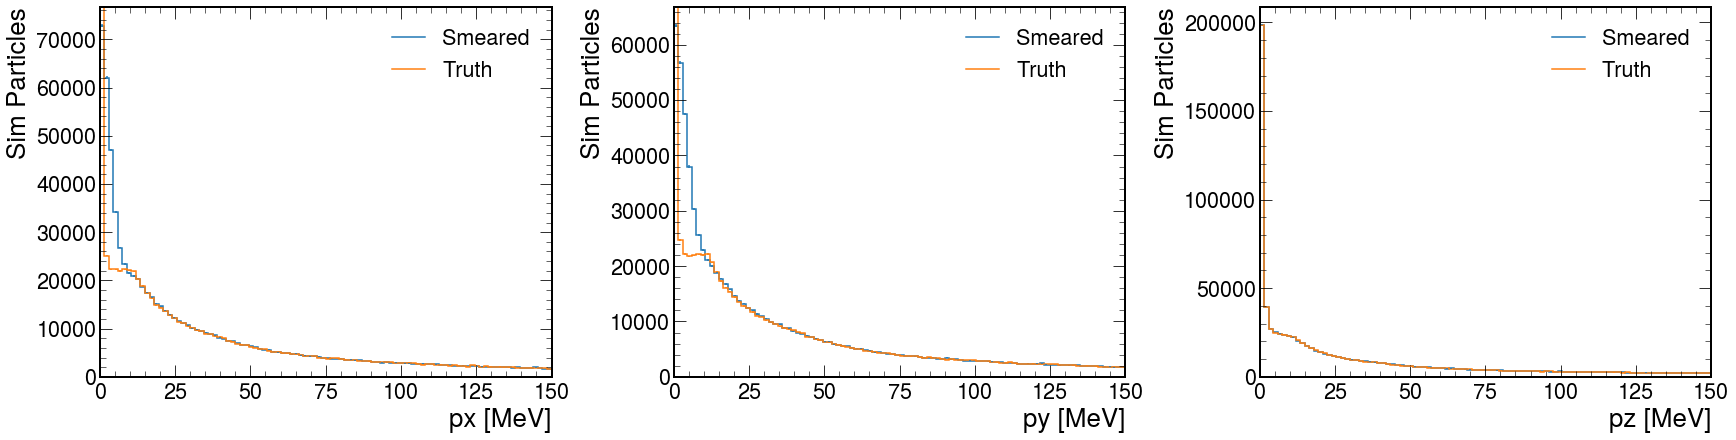

In [8]:
print(hists["px"])
fig, ax = plt.subplots(1,3,figsize=(24,6), constrained_layout=True)
hist.plot1d(hists["px_smeared"], ax=ax[0], clear = False);
hist.plot1d(hists["px"], ax=ax[0], clear = False);
hist.plot1d(hists["py_smeared"], ax=ax[1], clear = False);
hist.plot1d(hists["py"], ax=ax[1], clear = False);
hist.plot1d(hists["pz_smeared"], ax=ax[2], clear = False);
hist.plot1d(hists["pz"], ax=ax[2], clear = False);
ax[2].set_xlim(0, 150)
leg = ax[0].legend([r'Smeared', r'Truth'])
leg = ax[1].legend([r'Smeared', r'Truth'])
leg = ax[2].legend([r'Smeared', r'Truth'])